In [1]:
import pandas as pd
import numpy as np

print("Environment working!")


Environment working!


In [2]:
fake = pd.read_csv("../data/Fake.csv")
true = pd.read_csv("../data/True.csv")

print("Fake news shape:", fake.shape)
print("Real news shape:", true.shape)

fake.head()


Fake news shape: (23481, 4)
Real news shape: (21417, 4)


,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [3]:
fake["label"] = 0
true["label"] = 1

df = pd.concat([fake, true], axis=0).reset_index(drop=True)
df.head()


,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [4]:
df = df.drop_duplicates()
df.shape


(44689, 5)

In [5]:
df.isnull().sum()


title      0
text       0
subject    0
date       0
label      0
dtype: int64

In [6]:
# -----------------------------
# Import necessary NLP tools
# -----------------------------
import re                      # Regular expressions for text cleaning
import nltk                    # Natural Language Toolkit
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [7]:
# Download required NLTK data (run only once)
# -----------------------------
nltk.download("stopwords")     # List of common useless words (the, is, and...)
nltk.download("wordnet")       # Lemmatizer vocabulary

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DikelediMaholo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DikelediMaholo\AppData\Roaming\nltk_data...


True

In [8]:
# -----------------------------
# Prepare stopwords and lemmatizer
# -----------------------------
stop = set(stopwords.words("english"))     # Convert stopwords to a fast 'set'
lemm = WordNetLemmatizer()                 # Used to reduce words to base form

# -----------------------------
# Function to clean text
# -----------------------------
def clean_text(text):
    text = str(text).lower()               # 1. Convert to lowercase
                                           #    ("Hello" and "hello" become the same)

    text = re.sub(r"http\S+|www\S+", "", text)  
                                           # 2. Remove URLs (http://, https://, www...)

    text = re.sub(r"[^a-z ]", " ", text)   
                                           # 3. Remove all characters that are NOT letters
                                           #    (removes numbers, emojis, punctuation)

    words = text.split()                   # 4. Split sentence into individual words

    # 5. Remove stopwords AND apply lemmatization
    words = [
        lemm.lemmatize(word)               # Convert word to base form: "running" → "run"
        for word in words 
        if word not in stop                # Remove useless words like "the", "is", "and"
    ]

    return " ".join(words)                 # 6. Join the cleaned words back into a string


STEP 6 — Apply the Cleaning Function (with comments)

In [9]:
# Apply the clean_text() function to every row in the 'text' column
df["clean_text"] = df["text"].apply(clean_text)

# Display the original and cleaned version side-by-side
df[["text", "clean_text"]].head()


,text,clean_text
0,Donald Trump just couldn t wish all Americans ...,donald trump wish american happy new year leav...
1,House Intelligence Committee Chairman Devin Nu...,house intelligence committee chairman devin nu...
2,"On Friday, it was revealed that former Milwauk...",friday revealed former milwaukee sheriff david...
3,"On Christmas day, Donald Trump announced that ...",christmas day donald trump announced would bac...
4,Pope Francis used his annual Christmas Day mes...,pope francis used annual christmas day message...


STEP 7 — Convert Clean Text Into Numbers Using TF-IDF

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# -----------------------------
# Separate features (X) and labels (y)
# -----------------------------
X = df["clean_text"]
y = df["label"]

# -----------------------------
# Convert text into TF-IDF numeric vectors
# max_features = top 50000 words
# -----------------------------
tfidf = TfidfVectorizer(max_features=50000)
X_tfidf = tfidf.fit_transform(X)

print("TF-IDF shape:", X_tfidf.shape)


TF-IDF shape: (44689, 50000)


STEP 8 — Train the Logistic Regression Model

In [11]:
# ---------------------------------
# Import ML tools
# ---------------------------------
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ---------------------------------
# Split the TF-IDF vectors into train and test sets
# test_size=0.2 → 20% test, 80% train
# ---------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, 
    y, 
    test_size=0.2, 
    random_state=42
)

# ---------------------------------
# Initialize logistic regression model
# max_iter=500 ensures the model converges
# ---------------------------------
model_lr = LogisticRegression(max_iter=500)

# ---------------------------------
# Train the model (fit)
# ---------------------------------
model_lr.fit(X_train, y_train)

# ---------------------------------
# Predict on the test set
# ---------------------------------
y_pred = model_lr.predict(X_test)

# ---------------------------------
# Evaluate the model
# ---------------------------------
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.9873573506377266

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4738
           1       0.99      0.99      0.99      4200

    accuracy                           0.99      8938
   macro avg       0.99      0.99      0.99      8938
weighted avg       0.99      0.99      0.99      8938


Confusion Matrix:
[[4681   57]
 [  56 4144]]


Visualizing the confusion matrix

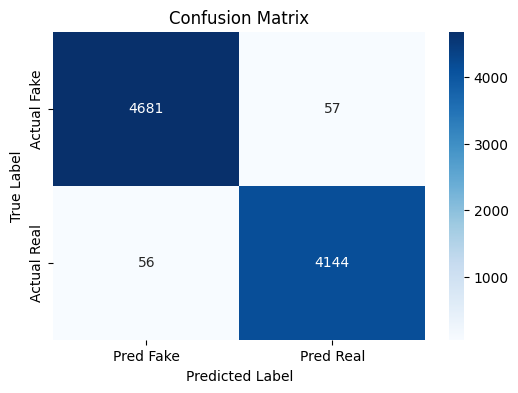

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# ---------------------------------
# Create Confusion Matrix
# ---------------------------------
cm = confusion_matrix(y_test, y_pred)

# ---------------------------------
# Plot the Confusion Matrix as a heatmap
# ---------------------------------
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Pred Fake', 'Pred Real'], 
            yticklabels=['Actual Fake', 'Actual Real'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
# ---------------------------------
# Import ML tools
# ---------------------------------
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ---------------------------------
# Split the TF-IDF vectors into train and test sets
# test_size=0.2 → 20% test, 80% train
# ---------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, 
    y, 
    test_size=0.2, 
    random_state=42
)

# ---------------------------------
# Initialize logistic regression model
# max_iter=500 ensures the model converges
# ---------------------------------
model_lr = LogisticRegression(max_iter=500)

# ---------------------------------
# Train the model (fit)
# ---------------------------------
model_lr.fit(X_train, y_train)

# ---------------------------------
# Predict on the test set
# ---------------------------------
y_pred = model_lr.predict(X_test)

# ---------------------------------
# Evaluate the model
# ---------------------------------
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.9873573506377266

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4738
           1       0.99      0.99      0.99      4200

    accuracy                           0.99      8938
   macro avg       0.99      0.99      0.99      8938
weighted avg       0.99      0.99      0.99      8938


Confusion Matrix:
[[4681   57]
 [  56 4144]]


Save the Trained Model and TF-IDF Vectorizer

In [13]:
import os

# Create models directory if it doesn't exist
if not os.path.exists("models"):
    os.makedirs("models")

print("models/ folder created")


models/ folder created


In [14]:
import joblib

# Save TF-IDF vectorizer
joblib.dump(tfidf, "models/tfidf_vectorizer.pkl")

# Save Logistic Regression model
joblib.dump(model_lr, "models/logistic_model.pkl")

print("Both model and vectorizer saved inside models/ folder.")



Both model and vectorizer saved inside models/ folder.


In [15]:
# Load back the saved model and vectorizer
loaded_tfidf = joblib.load("models/tfidf_vectorizer.pkl")
loaded_model = joblib.load("models/logistic_model.pkl")

# Test prediction
sample = ["The government announced new economic measures today."]
sample_clean = clean_text(sample[0])
sample_vec = loaded_tfidf.transform([sample_clean])

prediction = loaded_model.predict(sample_vec)
print("Prediction:", prediction)


Prediction: [0]


In [17]:
import os

# ----------------------------------
# 1. Create ONLY the needed folders
# ----------------------------------
folders = ["app", "src"]

for folder in folders:
    if not os.path.exists(folder):
        os.makedirs(folder)

print("Folders created: app/, src/")

# ----------------------------------
# 2. Create src/preprocess.py
# ----------------------------------
preprocess_code = """
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download resources
nltk.download("stopwords")
nltk.download("wordnet")

stop = set(stopwords.words("english"))
lemm = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\\\\S+|www\\\\S+", "", text)
    text = re.sub(r"[^a-z ]", " ", text)
    words = text.split()
    words = [lemm.lemmatize(w) for w in words if w not in stop]
    return " ".join(words)
"""

with open("src/preprocess.py", "w") as f:
    f.write(preprocess_code)

print("Created: src/preprocess.py")

# ----------------------------------
# 3. Create app/app.py
# ----------------------------------
app_code = """
import streamlit as st
import joblib
from src.preprocess import clean_text

# Load your trained model and vectorizer
tfidf = joblib.load("models/tfidf_vectorizer.pkl")
model = joblib.load("models/logistic_model.pkl")

st.title("📰 Fake News Detector")
st.write("Paste any news article text below and get an instant prediction!")

text = st.text_area("Enter news article text:")

if st.button("Analyze"):
    if text.strip() == "":
        st.warning("Please enter some text.")
    else:
        cleaned = clean_text(text)
        vec = tfidf.transform([cleaned])
        pred = model.predict(vec)[0]

        if pred == 1:
            st.success("✔ REAL NEWS")
        else:
            st.error("❌ FAKE NEWS")
"""

with open("app/app.py", "w", encoding="utf-8") as f:
    f.write(app_code)

print("Created: app/app.py")


Folders created: app/, src/
Created: src/preprocess.py
Created: app/app.py


In [18]:
import os
import shutil

# current location
src = "Notebooks/app"

# target location
dst = "app"

# move only if not already moved
if os.path.exists(src) and not os.path.exists(dst):
    shutil.move(src, dst)
    print("Moved app/ folder to root.")
else:
    print("app already in correct place or source not found.")


app already in correct place or source not found.


In [19]:
import os
import shutil

src = "Notebooks/app"   # correct relative path
dst = "app"             # move to root

# If source exists, move
if os.path.exists(src):
    shutil.move(src, dst)
    print("Moved app folder to root successfully.")
else:
    print("Source folder not found:", src)


Source folder not found: Notebooks/app


In [20]:
import os

print(os.listdir("."))


['01_data_exploration.ipynb', 'app', 'models', 'src']


In [21]:
import os

for root, dirs, files in os.walk(".", topdown=True):
    for d in dirs:
        print(os.path.join(root, d))


.\app
.\models
.\src
